In [102]:
1+1

2

In [161]:
import numpy as np
import cv2
import gym
from gym import spaces

class CaroEnv(gym.Env):
    def __init__(self, board_size=10):
        super(CaroEnv, self).__init__()
        self.board_size = board_size
        self.action_space = spaces.Discrete(board_size * board_size)
        self.observation_space = spaces.Box(low=0, high=255, shape=(1, 64, 64), dtype=np.uint8)
        self.reset()

    def reset(self):
        self.board = np.zeros((self.board_size, self.board_size), dtype=np.int8)
        self.current_player = 1
        self.done = False
        self.winner = None
        center = self.board_size // 2
        self.last_move = None
        return self.get_image()

    def step(self, action):
        if self.done:
            # Nếu game đã kết thúc từ lượt trước và người thắng không phải là mình → mình thua
            if self.winner != self.current_player:
                return self.get_image(), -1.0, True, {}
            else:
                raise ValueError("Game has finished. Call reset().")
    
        x, y = action
        if self.board[x, y] != 0:
            raise ValueError("Invalid move!")
    
        self.board[x, y] = self.current_player
        self.last_move = (x, y)
    
        reward = 0.0
    
        # Kiểm tra thắng
        if self.check_win(x, y):
            self.done = True
            self.winner = self.current_player
            reward = 3.0  # thắng thì +3
            return self.get_image(), np.clip(reward, -1.0, 5.0), True, {}
    
        # Kiểm tra hòa
        if np.all(self.board != 0):
            self.done = True
            reward = 1.0  # hòa thì +1
            return self.get_image(), np.clip(reward, -1.0, 5.0), True, {}
    
        # Shaping reward
        reward += self.get_chain_reward(x, y, self.current_player)
        reward += self.get_block_reward(x, y, self.current_player)
    
        # Đổi lượt
        self.current_player *= -1
    
        return self.get_image(), np.clip(reward, -1.0, 5.0), False, {}


    def get_image(self):
        img = np.zeros((self.board_size, self.board_size), dtype=np.uint8)
        img[self.board == 1] = 255
        img[self.board == -1] = 127
        img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_NEAREST)
        return img[np.newaxis, :, :]

    def check_win(self, x, y):
        player = self.board[x, y]
        for dx, dy in [(1,0),(0,1),(1,1),(1,-1)]:
            count = 1
            for d in [1, -1]:
                nx, ny = x + dx * d, y + dy * d
                while 0 <= nx < self.board_size and 0 <= ny < self.board_size and self.board[nx, ny] == player:
                    count += 1
                    nx += dx * d
                    ny += dy * d
            if count >= 5:
                return True
        return False

    def get_chain_reward(self, x, y, player):
        reward = 0.0
        for dx, dy in [(1,0),(0,1),(1,1),(1,-1)]:
            line = self.get_line(x, y, dx, dy)
            for chain_len, bonus in [(3, 0.4), (4, 0.6)]:
                if self.contains_chain(line, player, chain_len):
                    reward += bonus
        return reward

    def get_block_reward(self, x, y, player):
        reward = 0.0
        opponent = -player
        for dx, dy in [(1,0),(0,1),(1,1),(1,-1)]:
            line = self.get_line(x, y, dx, dy)
            if self.blocks_chain(line, opponent, 3):
                reward += 0.5
        return reward

    def get_line(self, x, y, dx, dy):
        """Trích xuất 9 ô dọc 1 hướng qua điểm (x,y)."""
        line = []
        for i in range(-4, 5):
            nx, ny = x + i * dx, y + i * dy
            if 0 <= nx < self.board_size and 0 <= ny < self.board_size:
                line.append(self.board[nx, ny])
            else:
                line.append(None)
        return line

    def contains_chain(self, line, player, length):
        count = 0
        for val in line:
            if val == player:
                count += 1
                if count == length:
                    return True
            else:
                count = 0
        return False

    def blocks_chain(self, line, opponent, length):
        for i in range(len(line) - length - 1):
            segment = line[i:i+length]
            if all(p == opponent for p in segment):
                before = line[i-1] if i-1 >= 0 else None
                after = line[i+length] if i+length < len(line) else None
                if (before == -opponent and after == 0) or (before == 0 and after == -opponent) or \
                   (before == 0 and after == 0):
                    return True
        return False


#======================Render====================================


    
    def render_board_viewer(self, ax=None):
        board = self.board
        board_size = self.board_size
    
        created_fig = False
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))
            created_fig = True
    
        # Vẽ lưới đúng theo ranh giới ô (0 đến board_size)
        ax.set_xticks(np.arange(0, board_size + 1, 1))
        ax.set_yticks(np.arange(0, board_size + 1, 1))
        ax.grid(True)
        ax.set_aspect('equal')
        ax.invert_yaxis()
    
        # Ẩn tick label mặc định
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    
        # VẼ CHỈ SỐ CỘT (ở dưới cùng)
        for i in range(board_size):
            ax.text(i + 0.5, board_size + 0.2, str(i), ha='center', va='center',
                    fontsize=10, color='black')
        
        # VẼ CHỈ SỐ HÀNG (bên trái)
        for i in range(board_size):
            ax.text(-0.5, i + 0.5, str(i), ha='center', va='center',
                    fontsize=10, color='black')

    
        # Vẽ X và O vào giữa ô
        for x in range(board_size):
            for y in range(board_size):
                if board[x, y] == 1:
                    ax.text(y + 0.5, x + 0.5, 'X', ha='center', va='center',
                            fontsize=14, color='blue')
                elif board[x, y] == -1:
                    ax.text(y + 0.5, x + 0.5, 'O', ha='center', va='center',
                            fontsize=14, color='red')
    
        # Hiển thị nếu không có ax truyền vào
        if created_fig:
            plt.tight_layout()
            plt.show()
    

    
        

    


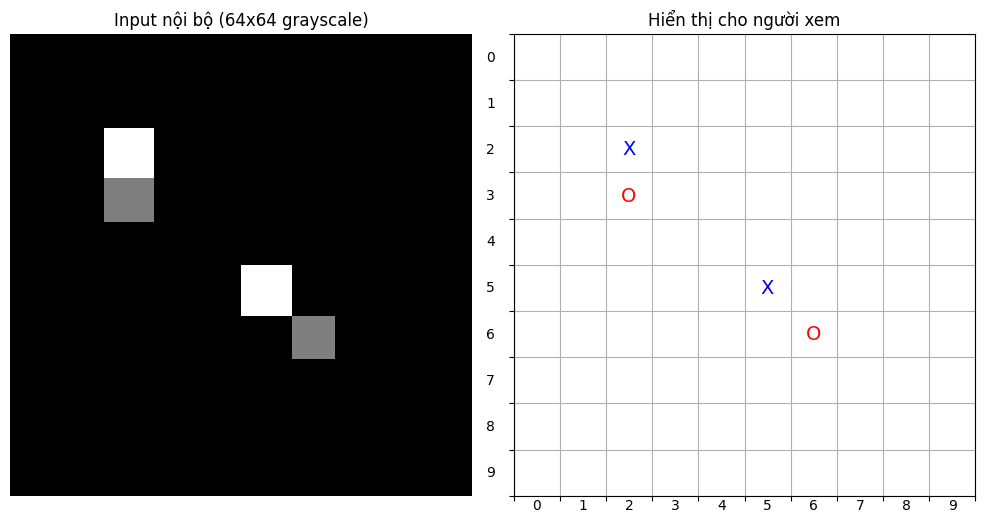

In [104]:
import matplotlib.pyplot as plt
import numpy as np
import cv2  # Nếu ảnh nội bộ cần resize

# === KHỞI TẠO ENV VỚI TRẠNG THÁI TÙY Ý ===
env = CaroEnv()
env.board[2, 2] = 1
env.board[3, 2] = -1
env.board[5, 5] = 1
env.board[6, 6] = -1

# === HIỂN THỊ ẢNH ===
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 1. ẢNH NỘI BỘ
img = env.get_image()[0]  # (64, 64), dtype=uint8
axes[0].imshow(img, cmap='gray', vmin=0, vmax=255)
axes[0].set_title("Input nội bộ (64x64 grayscale)")
axes[0].axis('off')

# 2. ẢNH CHO NGƯỜI XEM
env.render_board_viewer(ax=axes[1])  # HÀM PHẢI ĐƯỢC VIẾT CHO PHÉP NHẬN `ax`
axes[1].set_title("Hiển thị cho người xem")

plt.tight_layout()
plt.show()


In [105]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CaroDQN(nn.Module):
    def __init__(self, input_channels=4, input_size=64, board_size=10):
        super(CaroDQN, self).__init__()
        self.board_size = board_size  # 10x10 → 100 Q-values

        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),  # [B, 32, 64, 64]
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),               # [B, 64, 64, 64]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                                           # → [B, 64, 32, 32]

            nn.Conv2d(64, 128, kernel_size=3, padding=1),              # [B, 128, 32, 32]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                                           # → [B, 128, 16, 16]
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, board_size * board_size)  # Q-value cho mỗi ô
        )

    def forward(self, x):
        x = self.conv(x)  # Input: [B, 4, 64, 64]
        x = self.fc(x)
        return x  # Output: [B, 100]


In [106]:
import random
from collections import deque

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        # state, next_state: Tensor [1, 4, 64, 64]
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size, device):
        batch = random.sample(self.buffer, batch_size)
    
        states = torch.stack([s[0].float() for s in batch]).to(device)          # [B, 4, 64, 64]
        actions = torch.tensor([s[1] for s in batch], dtype=torch.long).to(device)
        rewards = torch.tensor([s[2] for s in batch], dtype=torch.float).to(device)
        next_states = torch.stack([s[3].float() for s in batch]).to(device)     # [B, 4, 64, 64]
        dones = torch.tensor([s[4] for s in batch], dtype=torch.bool).to(device)
    
        return states, actions, rewards, next_states, dones


    def __len__(self):
        return len(self.buffer)


In [107]:
from PIL import Image


def preprocess_state(board, device):
    """
    Chuyển trạng thái bảng (giá trị -1, 0, 1) thành ảnh grayscale [1, 64, 64]
    """
    if board.ndim == 3:
        board = board[0]  # bỏ kênh đầu nếu cần

    img = np.full((board.shape[0], board.shape[1]), 127, dtype=np.uint8)
    img[board == 1] = 255
    img[board == -1] = 0

    img = Image.fromarray(img).resize((64, 64), Image.NEAREST)
    img = np.array(img, dtype=np.uint8)

    img_tensor = torch.tensor(img, dtype=torch.float32, device=device) / 255.0
    return img_tensor.unsqueeze(0)  # [1, 1, 64, 64]


In [108]:
from collections import deque

class FrameStack:
    def __init__(self, k, device):
        self.k = k
        self.frames = deque(maxlen=k)
        self.device = device

    def reset(self, initial_board):
        frame = preprocess_state(initial_board, self.device)  # [1, 64, 64] -> [64, 64]
        self.frames = deque([frame for _ in range(self.k)], maxlen=self.k)
        return self.get_stack()

    def append(self, board):
        frame = preprocess_state(board, self.device)  # [1, 64, 64]
        self.frames.append(frame)
        return self.get_stack()

    def get_stack(self):
        return torch.cat(list(self.frames), dim=0)  # [1, 4, 64, 64]


In [129]:
import torch
import torch.nn.functional as F
import numpy as np
import random
import copy


def train_dqn_agent(env, agent, num_episodes, target_update_freq=10,
                    buffer_size=10000, batch_size=64, gamma=0.99,
                    epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.995):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    agent = agent.to(device)
    target_net = copy.deepcopy(agent).to(device)
    target_net.eval()

    optimizer = torch.optim.Adam(agent.parameters(), lr=1e-4)
    replay_buffer = ReplayBuffer(capacity=buffer_size)
    frame_stack = FrameStack(k=4, device=device)

    epsilon = epsilon_start
    all_avg_rewards = []
    all_avg_losses = []
    moving_avg_rewards = []
    moving_avg_losses = []

    window_size = 50

    for episode in range(num_episodes):
        board = env.reset()
        state = frame_stack.reset(board)  # [1, 4, 64, 64]
        
        total_reward = 0
        total_loss = 0
        update_count = 0
        done = False

        while not done:
            valid_actions = [i for i, v in enumerate(env.board.flatten()) if v == 0]

            if random.random() < epsilon:
                action_flat = random.choice(valid_actions)
            else:
                with torch.no_grad():
                    q_values = agent(state.unsqueeze(0))[0].cpu().numpy()
                    masked_q = np.full_like(q_values, -np.inf)
                    masked_q[valid_actions] = q_values[valid_actions]
                    action_flat = np.argmax(masked_q)

            board_size = env.board.shape[0]
            action = (action_flat // board_size, action_flat % board_size)
            next_board, reward, done, _ = env.step(action)
            next_state = frame_stack.append(next_board)  # [1, 4, 64, 64]

            replay_buffer.push(state, action_flat, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size, device)

                q_values = agent(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    target_q = target_net(next_states).max(1)[0]
                    targets = rewards + (1 - dones.float()) * gamma * target_q

                loss = F.mse_loss(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                update_count += 1

        if (episode + 1) % target_update_freq == 0:
            target_net.load_state_dict(agent.state_dict())

        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        avg_loss = total_loss / update_count if update_count > 0 else 0.0
        all_avg_rewards.append(total_reward)
        all_avg_losses.append(avg_loss)


        if (episode) % window_size == 0:
                        # === Tính moving average ===
            mean_reward = np.mean(all_avg_rewards[-window_size:])
            mean_loss = np.mean(all_avg_losses[-window_size:])
            moving_avg_rewards.append(mean_reward)
            moving_avg_losses.append(mean_loss)

            print(f"[Episode {episode}] Avg Reward (last {window_size}): {mean_reward:.2f} | Avg Loss: {mean_loss:.4f} | Epsilon: {epsilon:.3f}")

    return all_avg_losses, all_avg_rewards, moving_avg_losses, moving_avg_rewards


In [130]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

main_dqn = CaroDQN().to(device)

losses, rewards, avg_losses, avg_rewards = train_dqn_agent(
    env=env,
    agent=main_dqn,
    num_episodes=600,
    target_update_freq=10,
    buffer_size=10000,
    batch_size=64,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.1,
    epsilon_decay=0.995
)


[Episode 0] Avg Reward (last 50): 17.10 | Avg Loss: 0.1927 | Epsilon: 0.995
[Episode 50] Avg Reward (last 50): 10.98 | Avg Loss: 0.2767 | Epsilon: 0.774
[Episode 100] Avg Reward (last 50): 11.04 | Avg Loss: 0.4606 | Epsilon: 0.603
[Episode 150] Avg Reward (last 50): 9.71 | Avg Loss: 0.5753 | Epsilon: 0.469
[Episode 200] Avg Reward (last 50): 11.15 | Avg Loss: 0.7141 | Epsilon: 0.365
[Episode 250] Avg Reward (last 50): 12.07 | Avg Loss: 0.9389 | Epsilon: 0.284
[Episode 300] Avg Reward (last 50): 10.42 | Avg Loss: 0.9890 | Epsilon: 0.221
[Episode 350] Avg Reward (last 50): 9.73 | Avg Loss: 1.0677 | Epsilon: 0.172
[Episode 400] Avg Reward (last 50): 9.52 | Avg Loss: 1.0024 | Epsilon: 0.134
[Episode 450] Avg Reward (last 50): 11.22 | Avg Loss: 1.0452 | Epsilon: 0.104
[Episode 500] Avg Reward (last 50): 11.65 | Avg Loss: 1.1277 | Epsilon: 0.100
[Episode 550] Avg Reward (last 50): 10.64 | Avg Loss: 1.1063 | Epsilon: 0.100


In [131]:
len(losses)

600

In [132]:
len(avg_losses)

12

In [134]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_and_reward(losses, rewards, group_size=50):
    num_groups = len(rewards) // group_size

    avg_losses = []
    avg_rewards = []

    for i in range(num_groups):
        start = i * group_size
        end = start + group_size

        group_losses = losses[start:end]
        group_rewards = rewards[start:end]

        # Lọc loss khác None
        valid_losses = [l for l in group_losses if l is not None]

        if valid_losses:
            avg_losses.append(np.mean(valid_losses))
        else:
            avg_losses.append(np.nan)  # không có loss hợp lệ

        avg_rewards.append(np.mean(group_rewards))

    x = np.arange(num_groups) * group_size

    plt.figure(figsize=(12, 6))
    plt.plot(x, avg_losses, label='Avg Loss (per 50 ep)', marker='o')
    plt.plot(x, avg_rewards, label='Avg Reward (per 50 ep)', marker='x')
    plt.xlabel('Episode')
    plt.ylabel('Value')
    plt.title('Loss vs. Reward (Avg per 50 Episodes)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [138]:
# Lưu mô hình DQN sau huấn luyện
torch.save(main_dqn.state_dict(), "/kaggle/working/caro_dqn_eps_decay=995.pth")
print("✅ Đã lưu mô hình vào /kaggle/working/caro_dqn_eps_decay=995.pth")


✅ Đã lưu mô hình vào /kaggle/working/caro_dqn_eps_decay=995.pth


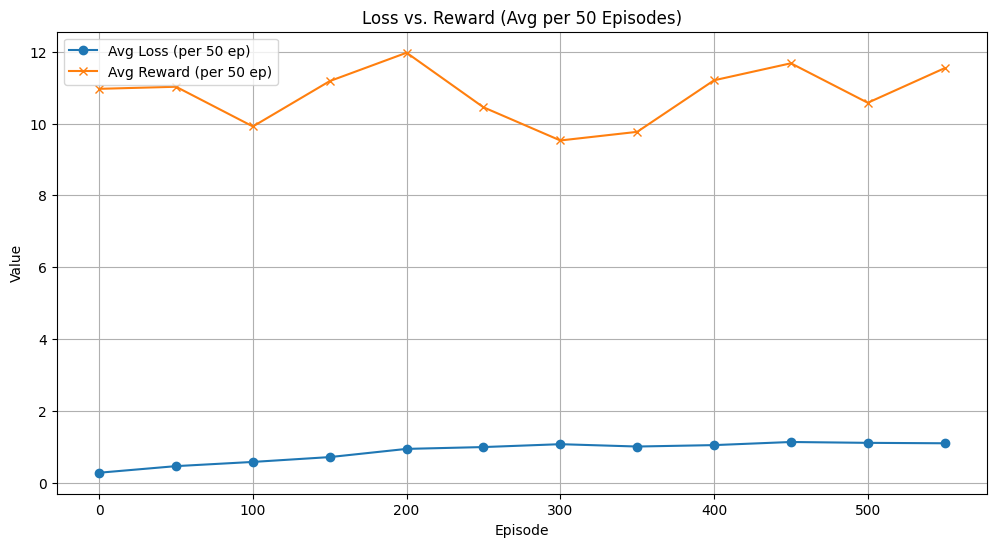

In [136]:
plot_loss_and_reward(losses, rewards)


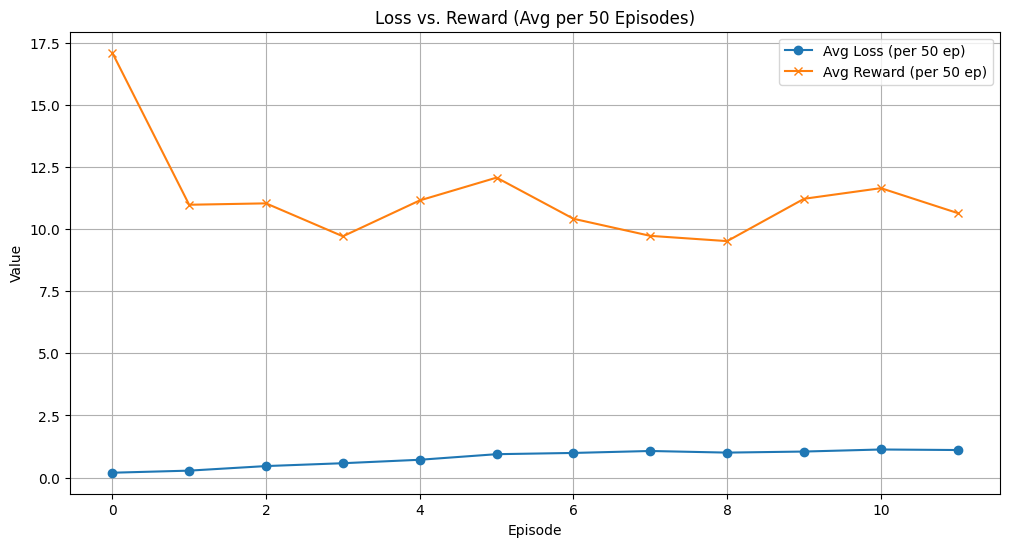

In [137]:
plot_loss_and_reward(avg_losses, avg_rewards, group_size=1)

In [ ]:

"""
# Load model
model = CaroDQN(input_channels=4, input_size=64, board_size=10)
model.load_state_dict(torch.load("/kaggle/working/caro_dqn_eps_decay=995.pth"))
model.eval()  # chuyển sang chế độ đánh giá (tắt dropout, batchnorm update)
"""

In [162]:
def select_action(state, agent, env):
    agent.eval()
    with torch.no_grad():
        q_values = agent(state.unsqueeze(0))[0].cpu().numpy()
        valid_actions = [i for i, v in enumerate(env.board.flatten()) if v == 0]
        masked_q = np.full_like(q_values, -np.inf)
        masked_q[valid_actions] = q_values[valid_actions]
        action_flat = np.argmax(masked_q)
    board_size = env.board.shape[0]
    return (action_flat // board_size, action_flat % board_size)


In [163]:
def play_against_agent(env, agent, frame_stack):
    board = env.reset()
    state = frame_stack.reset(board)

    env.render_board_viewer()

    while not env.done:
        # Agent chơi
        action = select_action(state, agent, env)
        board, _, done, _ = env.step(action)
        state = frame_stack.append(board)
        env.render_board_viewer()

        # Kiểm tra nếu Agent thắng
        x, y = action
        if env.check_win(x, y):
            print("Agent thắng!")
            break

        # Người chơi
        while True:
            try:
                x = int(input("Nhập dòng (0-based): "))
                y = int(input("Nhập cột (0-based): "))
                if env.board[x, y] == 0:
                    break
                else:
                    print("Ô đã đánh, thử lại.")
            except:
                print("Lỗi nhập. Nhập lại.")

        board, _, done, _ = env.step((x, y))
        state = frame_stack.append(board)
        env.render_board_viewer()

        # Kiểm tra nếu Người chơi thắng
        if env.check_win(x, y):
            print("Bạn thắng!")
            break

        # Kiểm tra hòa
        if env.done or (env.board == 0).sum() == 0:
            print("Hòa!")
            break


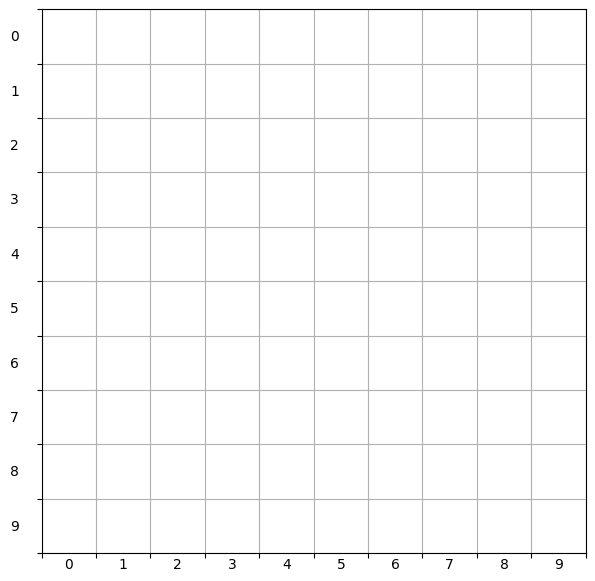

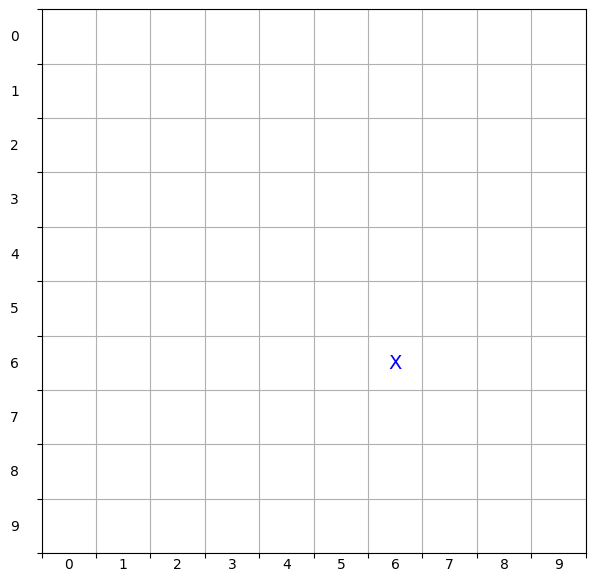

Nhập dòng (0-based):  5
Nhập cột (0-based):  7


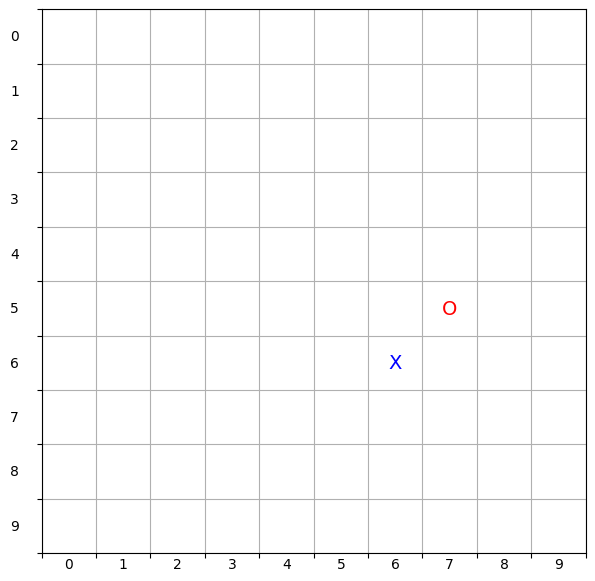

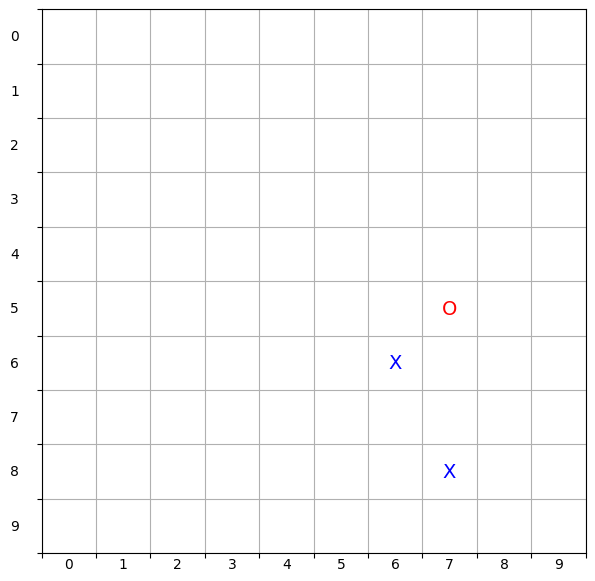

Nhập dòng (0-based):  5
Nhập cột (0-based):  6


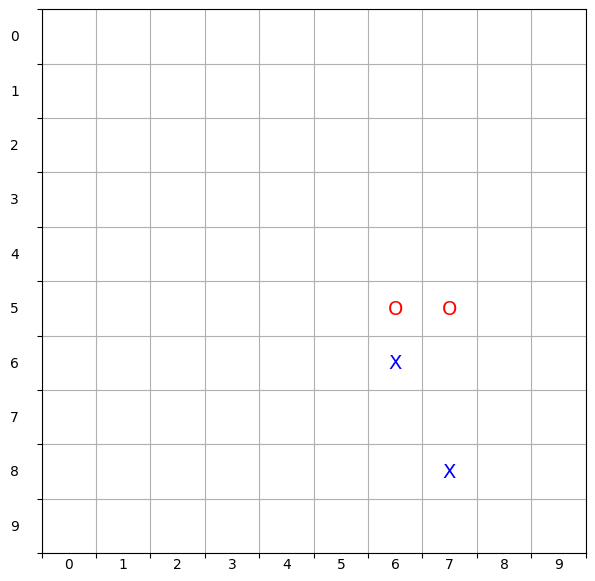

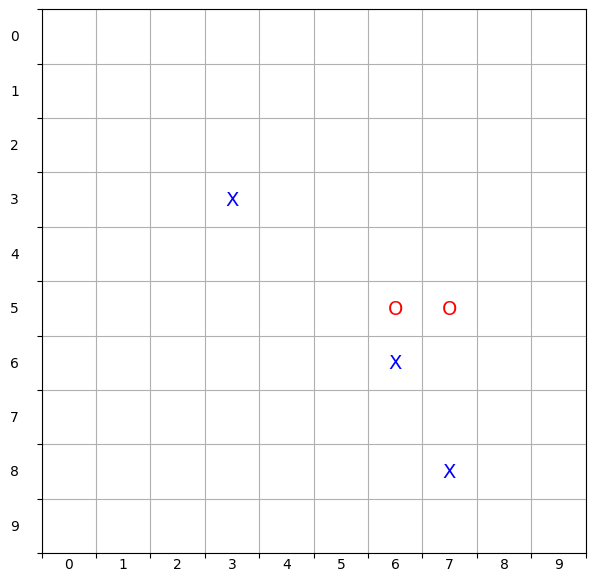

Nhập dòng (0-based):  5
Nhập cột (0-based):  5


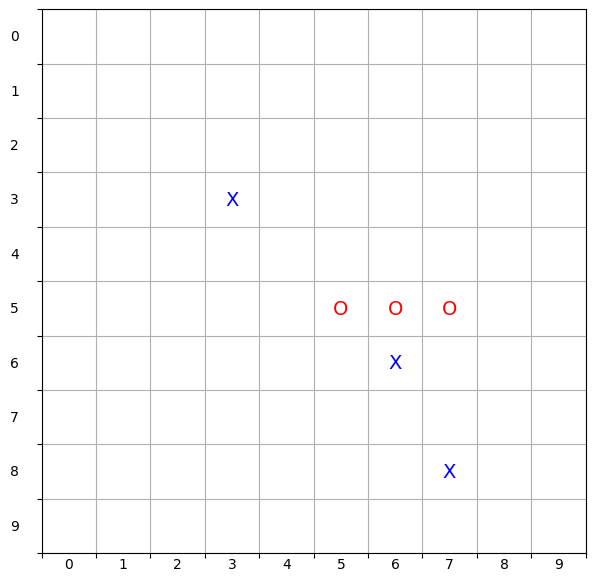

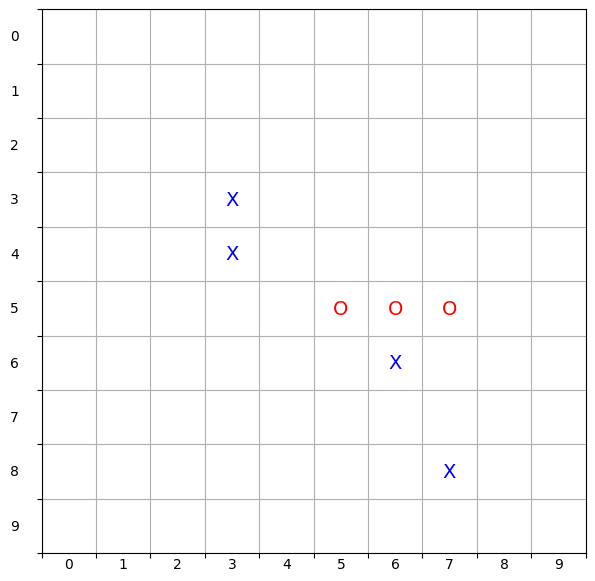

Nhập dòng (0-based):  5
Nhập cột (0-based):  4


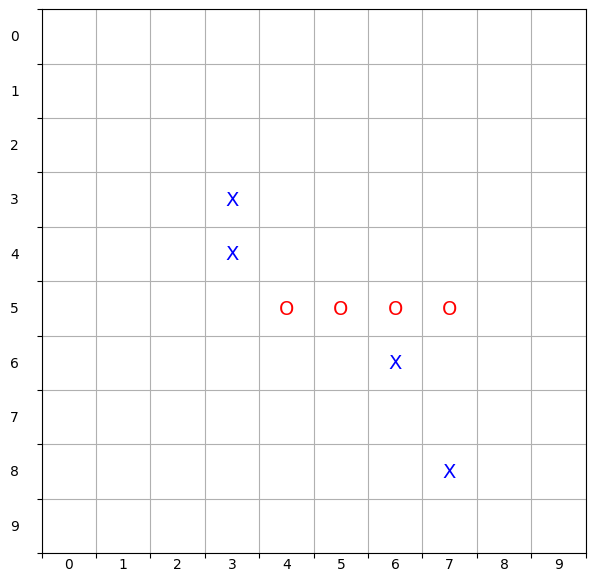

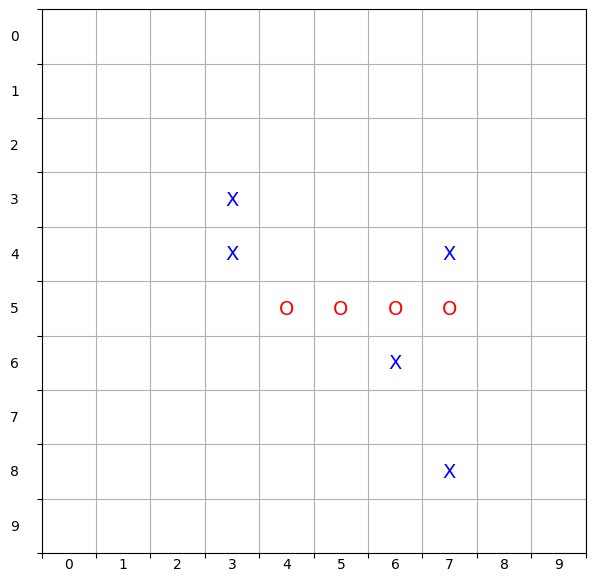

Nhập dòng (0-based):  5
Nhập cột (0-based):  3


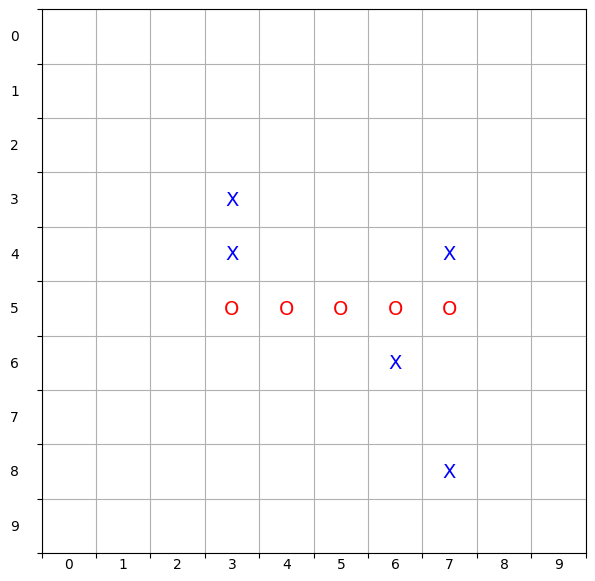

Bạn thắng!


In [164]:
play_against_agent(env, main_dqn, FrameStack(k=4, device=device))
